In [620]:

# librairie
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn

# pretraitement 
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, LabelBinarizer
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,learning_curve
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression, chi2 , f_classif, VarianceThreshold
from sklearn import set_config

# reechantillonnage 
from imblearn.over_sampling import SMOTE

# metrique d'evaluation 
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error,r2_score
from sklearn.model_selection import KFold, cross_val_score

# modele 
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge, Lasso
import xgboost as xgb
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import LocalOutlierFactor


### Analyse des données 

1. **Analyse de forme***

In [621]:
data = pd.read_csv("kaggle_train_set.csv")
df = data.copy()

In [622]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1180 entries, 0 to 1179
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   OverallQual   1180 non-null   int64 
 1   GrLivArea     1180 non-null   int64 
 2   TotalBsmtSF   1180 non-null   int64 
 3   1stFlrSF      1180 non-null   int64 
 4   YearBuilt     1180 non-null   int64 
 5   YearRemodAdd  1180 non-null   int64 
 6   GarageCars    1180 non-null   int64 
 7   GarageArea    1180 non-null   int64 
 8   FullBath      1180 non-null   int64 
 9   TotRmsAbvGrd  1180 non-null   int64 
 10  KitchenQual   1180 non-null   object
 11  Fireplaces    1180 non-null   int64 
 12  LotArea       1180 non-null   int64 
 13  Neighborhood  1180 non-null   object
 14  ExterQual     1180 non-null   object
 15  SalePrice     1180 non-null   int64 
dtypes: int64(13), object(3)
memory usage: 147.6+ KB


variable discretes : OverallQual, GarageCars, FullBath, TotRmsAbvGrd, Fireplaces
variable categorielles : KitchenQual, Neighborhood, ExterQual
variables Années :  YearBuilt, YearRemodAdd
variable continue : GrLivArea	TotalBsmtSF	1stFlrSF, GarageArea, LotArea, 	SalePrice

2. **Nettoyage des données**

In [623]:
# df.isna().sum() : il n' y pas des valeurs manquantes 

3. **Statistiques Univariés**

     **Barplot des variables discretes**

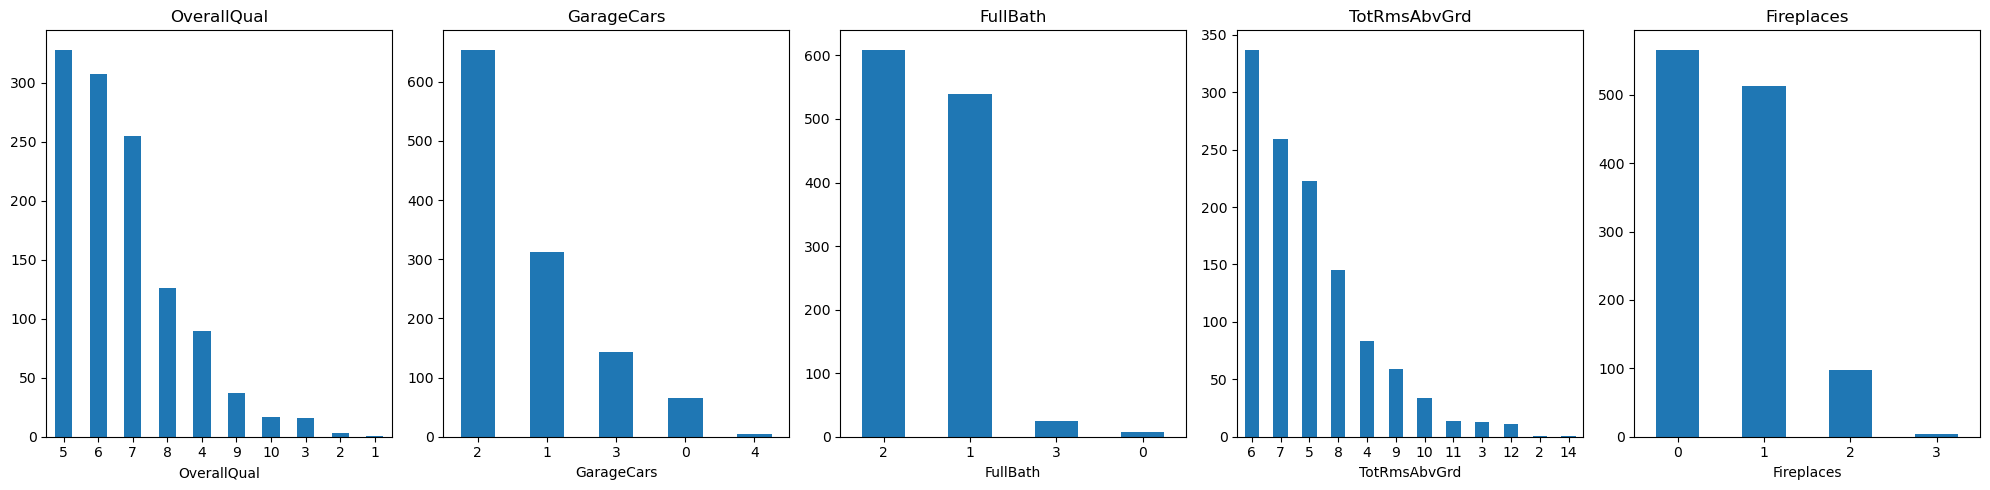

In [624]:
variable_discretes = ["OverallQual", "GarageCars", "FullBath", "TotRmsAbvGrd", "Fireplaces"]

fig, axes = plt.subplots(nrows=1, ncols=len(variable_discretes), figsize=(20, 5))  

for ax, col in zip(axes, variable_discretes):
    df[col].value_counts().plot(kind="bar", ax=ax, title=col, rot=0)

plt.tight_layout()  # Ajuste les espacements pour éviter le chevauchement
plt.show()

**Histograme des variables continues**

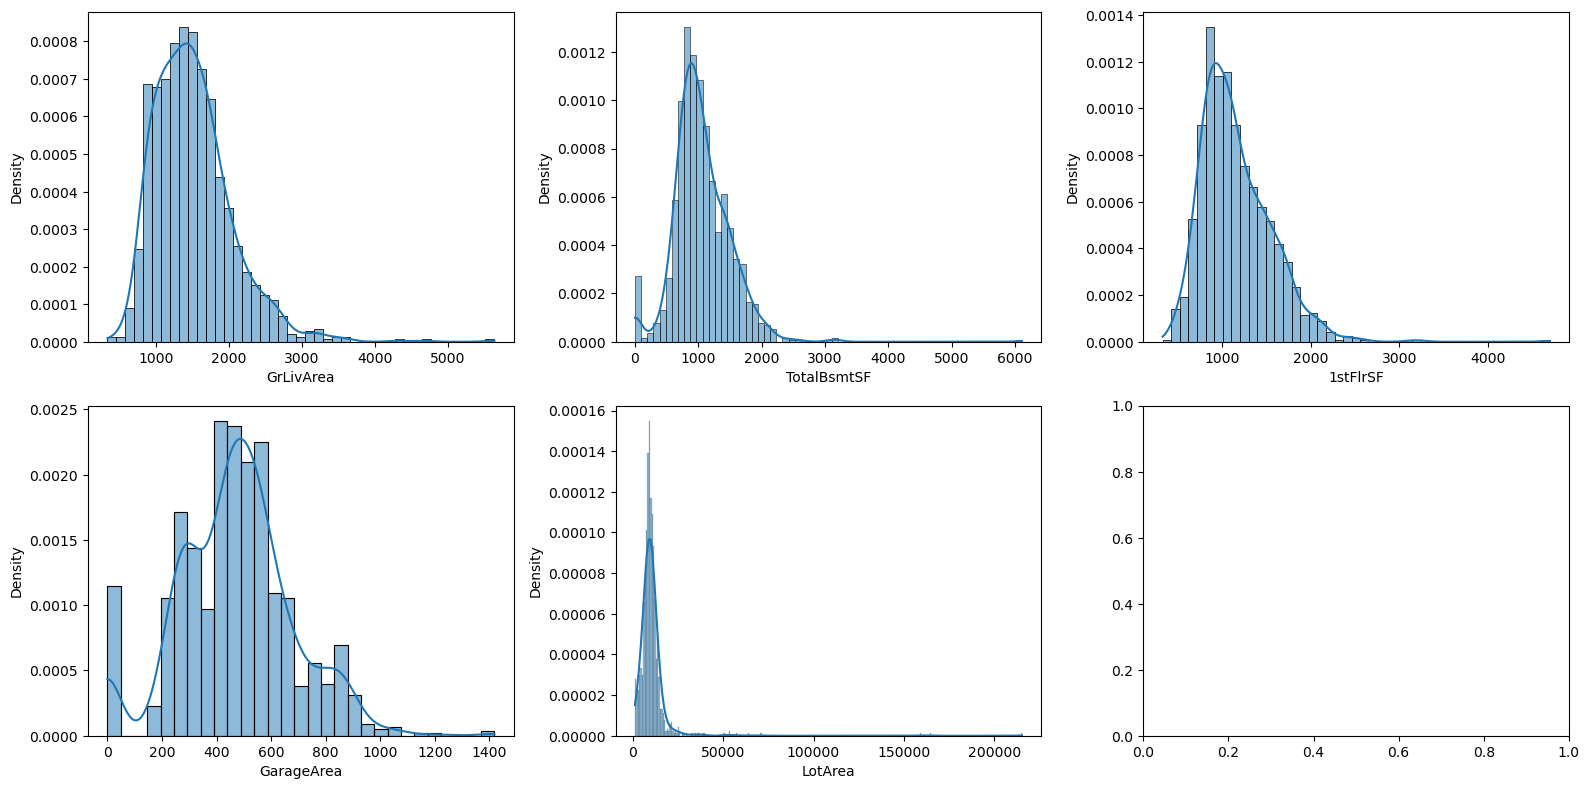

In [625]:
variable_continue =["GrLivArea","TotalBsmtSF", "1stFlrSF", "GarageArea", "LotArea"]

fig, axes = plt.subplots(nrows=2,ncols=3, figsize=(16, 8))  
axes = axes.flatten()  
for ax, col in zip(axes, variable_continue):
    sns.histplot(data=df, x=col, kde=True, stat="density", ax=ax)

plt.tight_layout()  
plt.show()


Ces variable montresnt une distribution asymetrique à droite et ayant  des valeurs aberrante qui s'eloignent de la moyenne
Ainsi il est necessaire des les analyser et effectué des transformation : logarithmique ou une normalisation 

*Variable cible prix de l'immobilier* 

In [626]:
df["SalePrice"].describe()

count      1180.000000
mean     179822.169492
std       79703.346024
min       34900.000000
25%      128800.000000
50%      161250.000000
75%      212000.000000
max      755000.000000
Name: SalePrice, dtype: float64

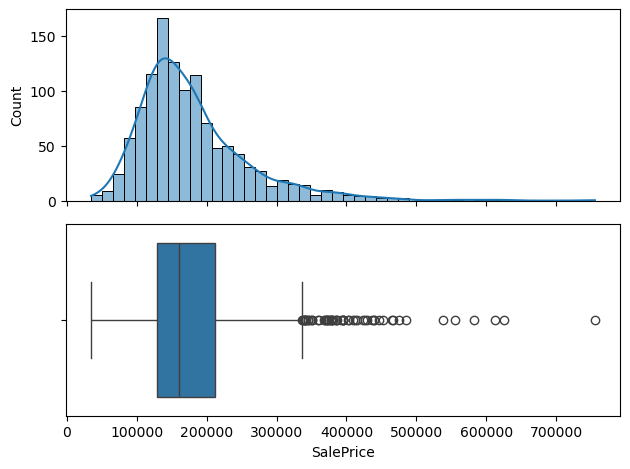

In [627]:
fig,ax = plt.subplots(2,1, sharex=True)
sns.histplot(data=df, x="SalePrice",ax=ax[0],kde=True)
sns.boxplot(data=df, x="SalePrice", ax = ax[1])
plt.tight_layout()
plt.show()


La figure ci-dessus montre une distribution asymetrique à droite indiquant que la majorité des prix de vente sont concentrés dans les valeurs plus basses, tandis que quelques maisons ont des prix très élevés.  
- 75 % des maisons ont un prix inférieur à 212 000 dollars (Q3 = 3ᵉ quartile).  

- 25 % des maisons ont un prix inférieur à 128 800 dollars (Q1 = 1ᵉʳ quartile).  
- Les prix dépassant 300 000 dollars sont considérés comme extrêmes 

**Fonction pour detecter les outliers**

In [628]:
def detection_outlier(data, col, threshold=1.5):
    variable = data[col]
    q1 = variable.quantile(0.25)
    q3 = variable.quantile(0.75)
    iqr = q3-q1
    lower_bound = q1 - threshold*iqr
    upper_bound = q3 + threshold*iqr
    outliers = data[(variable<lower_bound) | (variable >upper_bound)]
    return outliers

In [629]:
data_bis= detection_outlier(data=df,col="SalePrice")
data_bis.sort_values(by="SalePrice",ascending=False).head(5)


,OverallQual,GrLivArea,TotalBsmtSF,1stFlrSF,YearBuilt,YearRemodAdd,GarageCars,GarageArea,FullBath,TotRmsAbvGrd,KitchenQual,Fireplaces,LotArea,Neighborhood,ExterQual,SalePrice
562,10,4316,2444,2444,1994,1995,3,832,3,10,Ex,2,21535,NoRidge,Ex,755000
941,10,3627,1930,1831,1995,1996,3,807,3,10,Gd,1,35760,NoRidge,Gd,625000
732,9,2364,2330,2364,2009,2010,3,820,2,11,Ex,2,12919,NridgHt,Ex,611657
652,9,2822,1734,1734,2008,2009,3,1020,3,12,Ex,1,13891,NridgHt,Ex,582933
355,10,2402,3094,2402,2008,2008,3,672,2,10,Ex,2,15431,NridgHt,Ex,555000


**Barplot des variables categorielle**

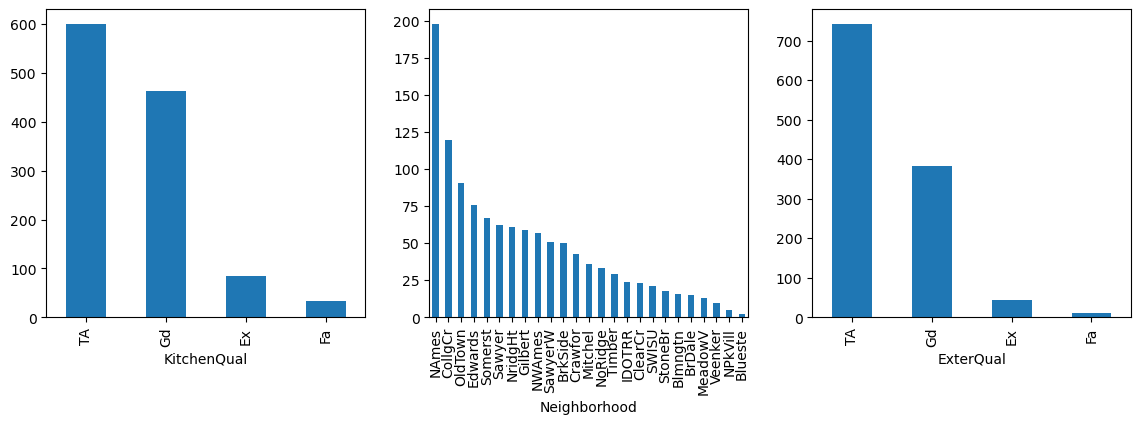

In [630]:
variable_categorielles =["KitchenQual", "Neighborhood", "ExterQual"]

fig, axes = plt.subplots(nrows=1, ncols=len(variable_categorielles), figsize=(14, 4))
for ax,col in zip(axes, variable_categorielles):
    df[col].value_counts().plot(kind="bar", rot=90, ax=ax)

Interpretation : 

4. **Statistiques multivariées**

 - **Relation entre les variables continues  et le prix**
    

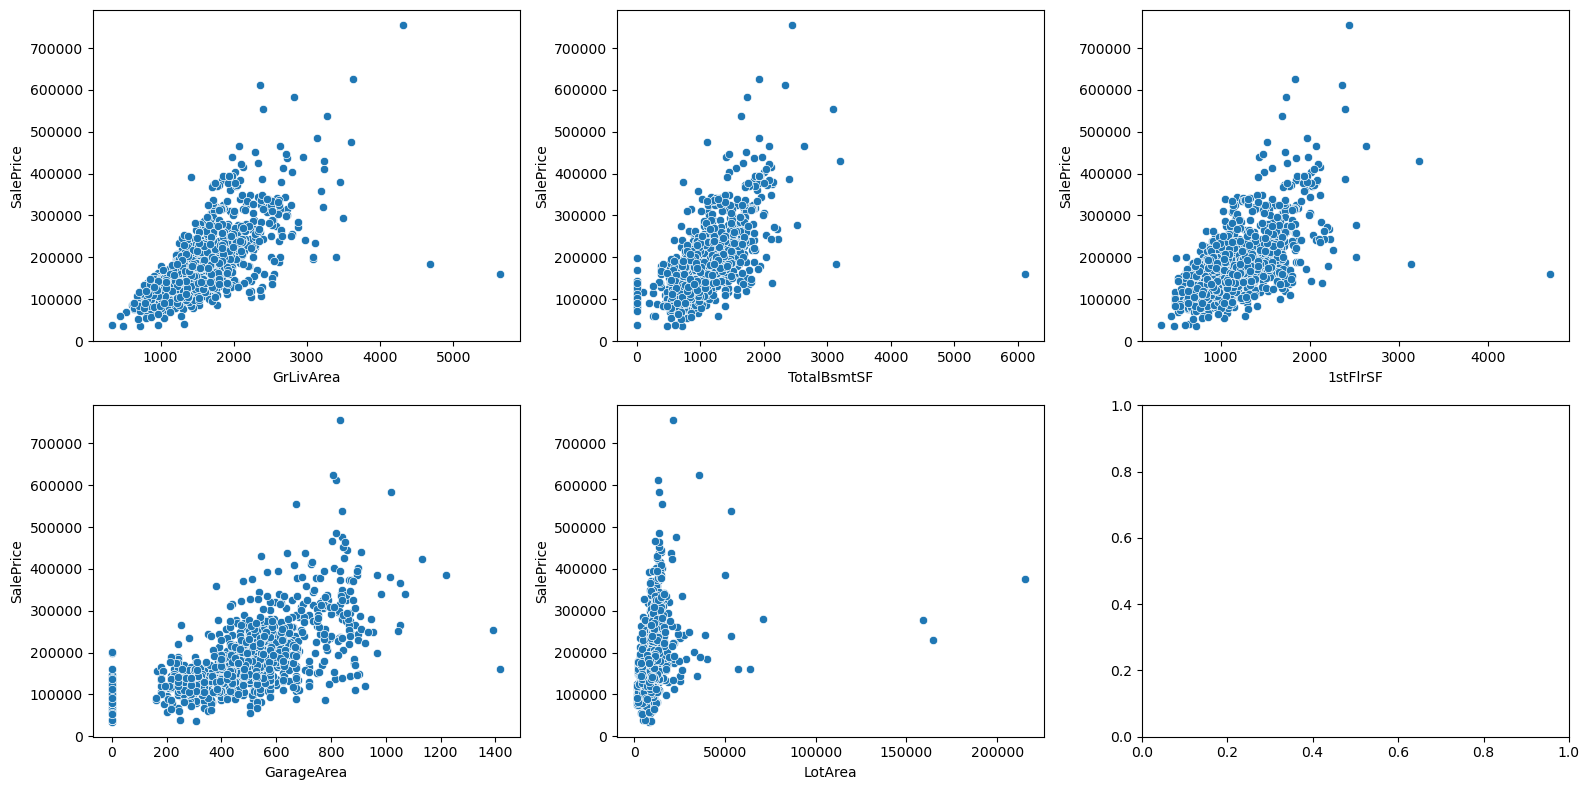

In [631]:
variable_continue =["GrLivArea","TotalBsmtSF", "1stFlrSF", "GarageArea", "LotArea"]

fig, axes = plt.subplots(nrows=2,ncols=3, figsize=(16, 8))  
axes = axes.flatten()  
for ax, col in zip(axes, variable_continue):
    sns.scatterplot(data=df, x=col, y="SalePrice",ax=ax)

plt.tight_layout()  
plt.show()

In [632]:
def localoutlierFactor(X,y, contamination=0.02, n_neighbors=5):

    X = np.array(X).reshape(-1, 1)  
    y = np.array(y).reshape(-1, 1)
    data = np.concatenate((X,y), axis=1)
    detection_modele = LocalOutlierFactor(contamination=contamination, n_neighbors=n_neighbors)
    outliers = detection_modele.fit_predict(data)
     
    # Extraction des indices des outliers
    outlier_indices = np.where(outliers == -1)[0]
    
    plt.scatter(X,y, c=outliers, cmap="bwr_r")
    return outlier_indices


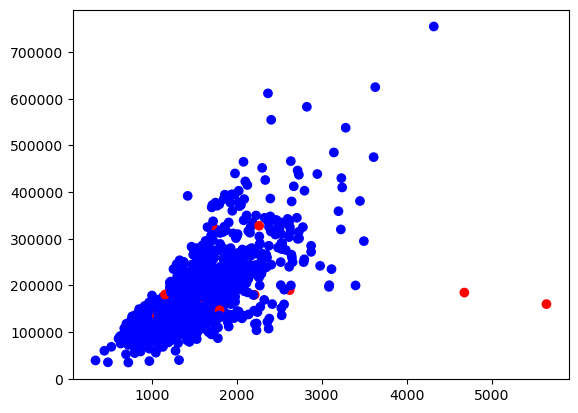

In [633]:
outlier_indices = localoutlierFactor(X=data["GrLivArea"], y=data["SalePrice"])
# Extraire les valeurs aberrantes 
outliers = data.iloc[outlier_indices]

- **Relation entre la Variable prix et les variable Discretes**

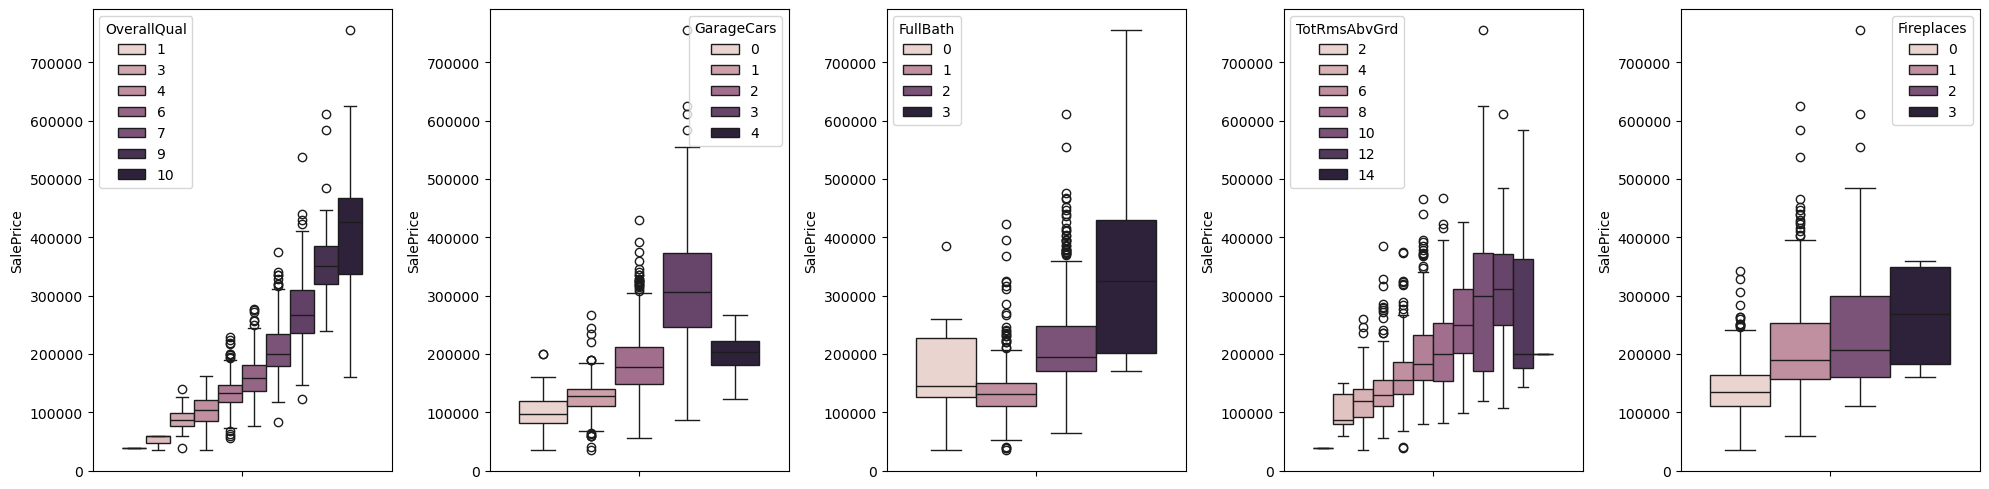

In [634]:
variable_discretes = ["OverallQual", "GarageCars", "FullBath", "TotRmsAbvGrd", "Fireplaces"]

fig, axes = plt.subplots(nrows=1, ncols=len(variable_discretes), figsize=(20, 5))  # Ajuste la taille selon le besoin

for ax, col in zip(axes, variable_discretes):
    sns.boxplot(data=df, y="SalePrice",hue=col, ax=ax)

plt.tight_layout()  
plt.show()

interpretation : 
- La qualité globale des matériaux et de la finition est corrélée avec le prix (noté sur 10). Plus elle est élevée, plus le prix est élevé.
- Il en va de même pour le nombre de salles de bain (0, 1, 2, 3).
- Nous observons également cette tendance pour le nombre de cheminées (0, 1, 2, 3).

Prix de vente par tranche d'année de Construction 

In [635]:
def fonction_decoupage_annnes(df):
    # decoupe par decenie pour années de renovation 
    bins = [1950, 1960, 1970, 1980, 1990, 2000, 2010]  
    labels = ['1950s', '1960s', '1970s', '1980s', '1990s', '2000s']
    df['DecadeRemodAdd'] = pd.cut(df['YearRemodAdd'], bins=bins, labels=labels,include_lowest=True, right=True)
    
    # decoupage par decenie pour les années de construction 
    bins = [1870, 1880, 1890, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]
    labels = ["1870s", "1880s", "1890s", "1900s", "1910s", "1920s", "1930s", "1940s", "1950s", "1960s", "1970s", "1980s", "1990s", "2000s"]
    df["DecadeBuilt"] = pd.cut(df["YearBuilt"], bins=bins, labels=labels,include_lowest=True, right=True)
    
    # suppressions des variables année de construction et de renovation 
    df.drop(columns=["YearBuilt","YearRemodAdd"], axis=1, inplace=True)
    
    return df
    

In [636]:
df = fonction_decoupage_annnes(df)

In [637]:
# la moyenne des prix par décennie
df.groupby("DecadeRemodAdd",observed=False)["SalePrice"].mean()

DecadeRemodAdd
1950s    121615.219409
1960s    144916.078740
1970s    149446.796748
1980s    181094.393939
1990s    204393.284483
2000s    220783.754430
Name: SalePrice, dtype: float64

In [638]:
#  la moyenne des prix par décennie
df.groupby("DecadeBuilt",observed=False)["SalePrice"].mean()

DecadeBuilt
1870s    169746.500000
1880s    142500.000000
1890s    166925.090909
1900s    114056.500000
1910s    123340.033898
1920s    126368.225806
1930s    149771.100000
1940s    124214.388889
1950s    144179.579710
1960s    150054.684211
1970s    154819.072464
1980s    198941.923077
1990s    228700.765957
2000s    245990.371429
Name: SalePrice, dtype: float64

**Prix de vente par tranche d'année de renovation**

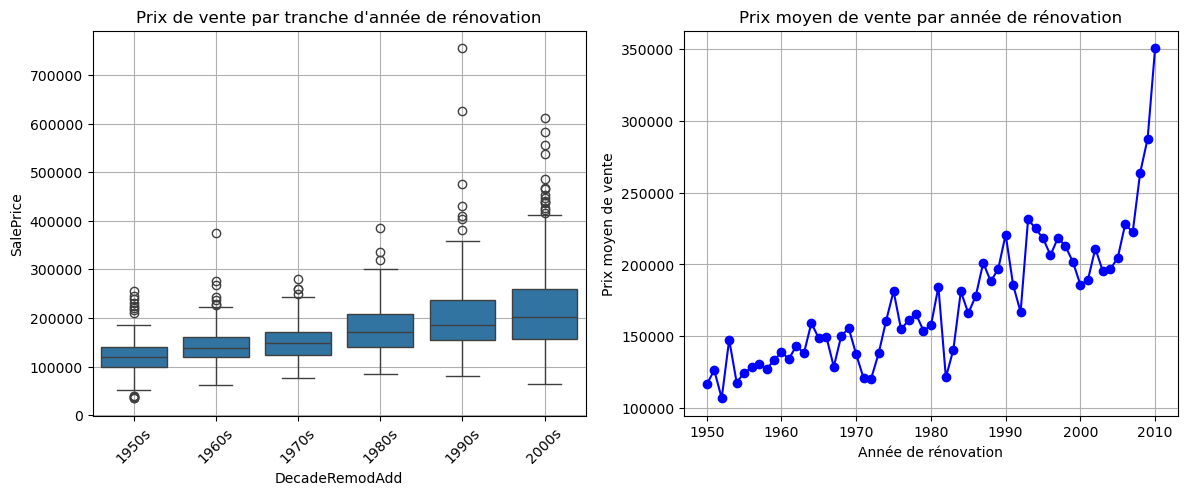

In [639]:
fig, axes = plt.subplots(1,2,figsize=(14,5))

sns.boxplot(data=df, x="DecadeRemodAdd", y="SalePrice", ax=axes[0])
axes[0].set_title("Prix de vente par tranche d'année de rénovation")
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True)

# Calculer la moyenne des prix par année
prix_moyen_par_année = data.groupby("YearRemodAdd",observed=False)["SalePrice"].mean()

# Tracer le graphique linéaire
axes[1].plot(prix_moyen_par_année.index, prix_moyen_par_année.values, marker='o', linestyle='-', color='blue')
axes[1].set_xlabel('Année de rénovation')
axes[1].set_ylabel('Prix moyen de vente')
axes[1].set_title('Prix moyen de vente par année de rénovation')
axes[1].grid(True)

# Afficher la figure
plt.show()

- On observe une augmentation progressive du prix de vente des maisons en fonction de la décennie de rénovation.Les maisons rénovées plus récemment (1990s et 2000s) ont en général des prix de vente plus élevés que celles rénovées dans les années 1950s ou 1960s. La médiane du prix de vente augmente avec la modernité de la rénovation. On constate également une dispersion plus importante des prix dans les décennies récentes, avec plusieurs valeurs extrêmes (outliers)

- Le graphique à droitemontre une tendance à la hausse des prix moyens de vente au fil des années de rénovation. La courbe présente une croissance plus marquée à partir des années 2000, avec une forte accélération après 2005. La hausse exponentielle à la fin du graphique (vers 2010) indique que les maisons rénovées très récemment sont vendues à des prix nettement plus élevés.


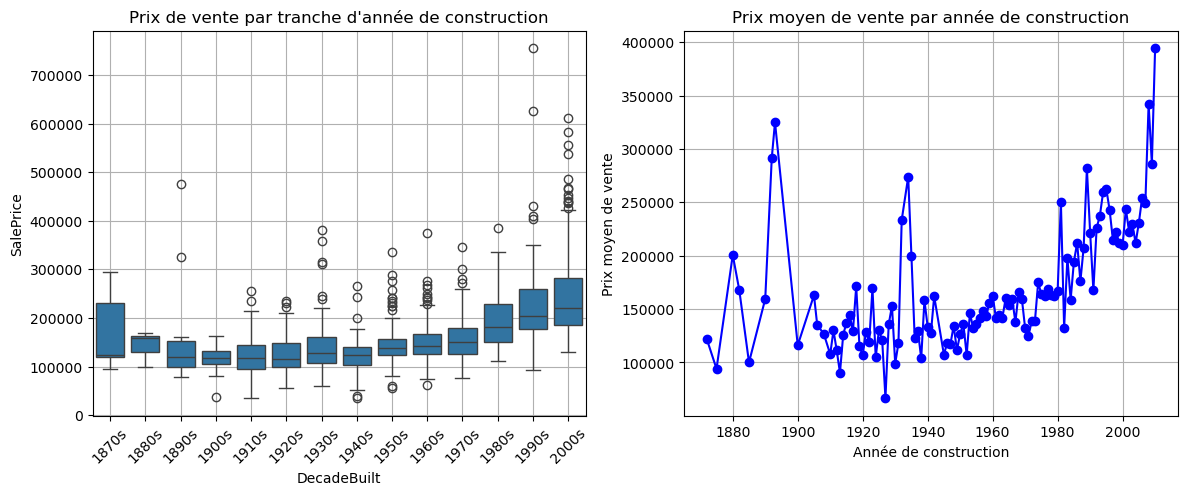

In [640]:
fig, axes = plt.subplots(1,2,figsize=(14,5))

sns.boxplot(data=df, x="DecadeBuilt", y="SalePrice", ax=axes[0])
axes[0].set_title("Prix de vente par tranche d'année de construction")
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True)

# la moyenne des prix par année
prix_moyen_par_année = data.groupby("YearBuilt",observed=False)["SalePrice"].mean()

# Tracer le graphique linéaire
axes[1].plot(prix_moyen_par_année.index, prix_moyen_par_année.values, marker='o', linestyle='-', color='blue')
axes[1].set_xlabel('Année de construction')
axes[1].set_ylabel('Prix moyen de vente')
axes[1].set_title('Prix moyen de vente par année de construction')
axes[1].grid(True)


plt.show()

 interpretation : 
- On remarque que les maisons construites avant 1950 ont globalement des prix de vente plus faibles et plus homogènes, avec une faible dispersion.
À partir des années 1970, on observe une augmentation des prix de vente ainsi qu’une plus grande dispersion des prix.
Les maisons construites dans les années 2000 ont les prix les plus élevés, avec plusieurs valeurs extrêmes dépassant les 500 000 dollars.

- pour le graphique de droite  
On observe une évolution irrégulière des prix de vente pour les maisons anciennes, avec des pics de prix élevés pour certaines années avant 1900 et autour de 1940.
À partir des années 1950, la tendance générale est à la hausse, avec une accélération plus marquée après 1980.
Après 2000, les prix connaissent une forte augmentation, atteignant des niveaux records. 

**Relation entre les variable categorielle et le prix**

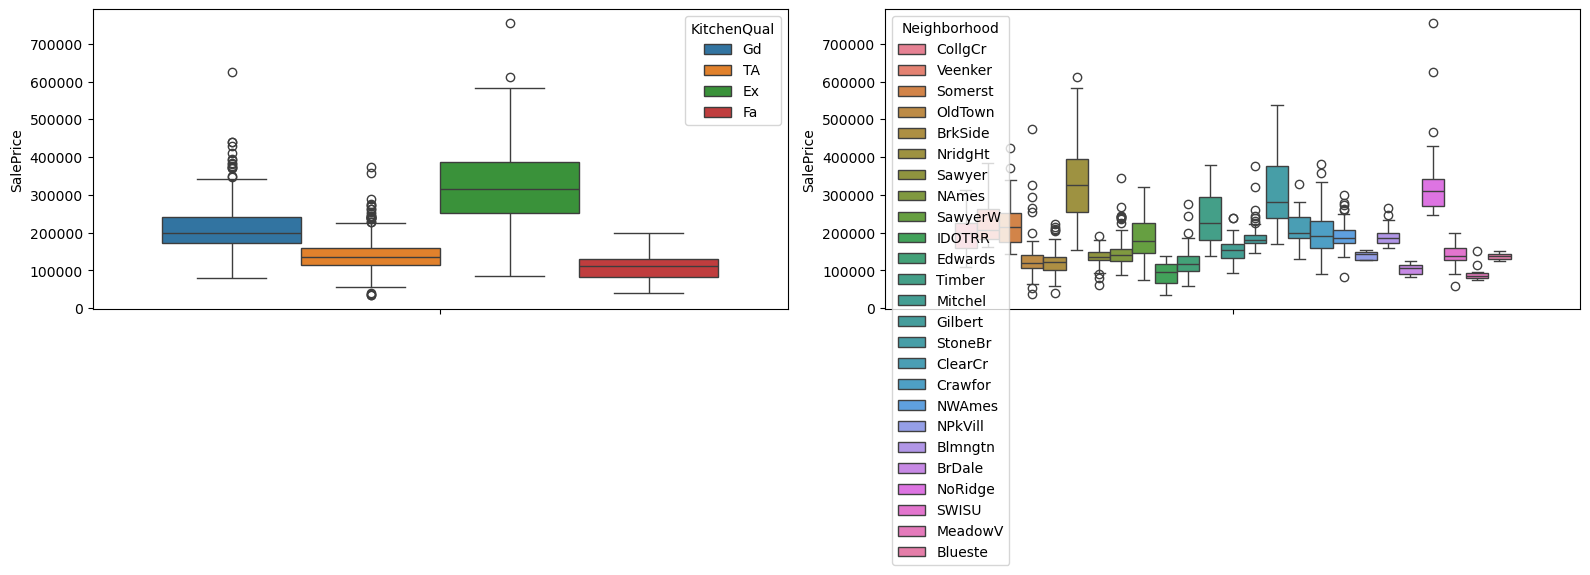

In [641]:
variable_categorielles =["KitchenQual", "Neighborhood"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5)) 

for ax, col in zip(axes, variable_categorielles):
    sns.boxplot(data=df, y="SalePrice",hue=col, ax=ax)

plt.tight_layout()  
plt.show()
    

**Analyses des correlation** 

   - Correlation des variables continue

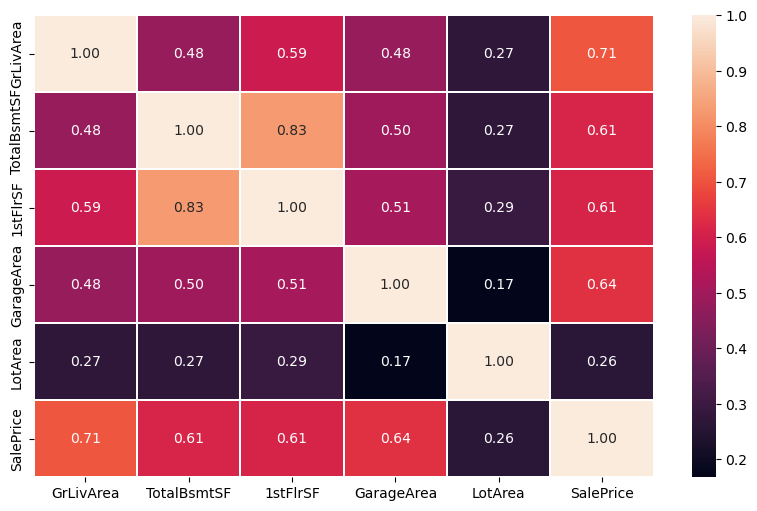

In [642]:
# 
variable_continue = ['GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'GarageArea', 'LotArea',"SalePrice"]
df_con = df[variable_continue]
corr = df_con.corr(method = 'pearson')
plt.figure(figsize=(10,6)) # dpi =500 augmente la taille de l'image 
sns.heatmap(corr,annot=True,fmt=".2f", linewidth=.2)
plt.show()

- la variable LotArea n'est pas corrélé avec le prix (la variable LotArea ne sera pas inclut dans le modele )
- la variable TotalBsmtSF et 1stFlrSF sont correlé entre eux donc il faudra supprimé l'une de ces variables (idéalement celle qui est moins corrélé avec le prix)
- la variable diff_année est corrélé negativement

5. **Tests Statistiques**

In [643]:
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency

  1. Test statistique pour voir si il y'a les différences de prix entre quartiers sont significatives 
     - ANOVA (ANalysis Of VAriance) : Test statistique pour comparer les moyennes.

In [644]:
ma_list = df.groupby("Neighborhood")["SalePrice"].apply(list)
print(f_oneway(*ma_list))
1/f_oneway(*ma_list).pvalue

F_onewayResult(statistic=62.91323996536989, pvalue=2.6683172951041164e-190)


3.747680239658232e+189

In [645]:
print("H0:\"Il n' y a pas de difference de prix significative entre les Quartier \"")
print()
alpha = 0.02
p_value = f_oneway(*ma_list).pvalue

if p_value < alpha :
    print("Nous avons suffisamment d'evidences pour rejeter H0")
else : 
    print("Nous n'avons pas suffisamment d'evidence pour rejeter H0") 

H0:"Il n' y a pas de difference de prix significative entre les Quartier "

Nous avons suffisamment d'evidences pour rejeter H0


2. Relation entre deux variables catégorielles
   * Nous voulons verifier si il y'a une dépendance entre les catégories.
        - Tableau de contingence (fréquences croisées)
        - Test du Khi² (Chi-square test)

In [646]:
# Tableau de contingence
contingency_table = pd.crosstab(df["OverallQual"], df["GarageCars"])
print("H0:\"il y'a une dépendance entre ces deux catégories \"")
print()
alpha = 0.02
p_value = chi2_contingency(contingency_table).pvalue

if p_value < alpha :
    print("Nous avons suffisamment d'evidences pour rejeter H0")
else : 
    print("Nous n'avons pas suffisamment d'evidence pour rejeter H0") 

H0:"il y'a une dépendance entre ces deux catégories "

Nous avons suffisamment d'evidences pour rejeter H0


Il n' y a de dependance entre les variable categorielle, discrte 

### Pretraitement des données

Suppression de certaines variables  
- Suppression de la variable LotArea moins corrélé avec le prix   
- suppression de la variable 1stFlrSF car fortement corrélé avec TotalBsmtSF

Suppression des outliers   

In [647]:
df = df[df["TotalBsmtSF"]<4000]
df = df[df["GrLivArea"]<4000]
df = df[df["SalePrice"]<=500000]

In [648]:
df_final = df.copy()
X,y = df_final.drop("SalePrice", axis=1), np.log(df_final["SalePrice"])

Encodage des variables 

In [649]:
choix_variable = ["KitchenQual","ExterQual","DecadeRemodAdd","GrLivArea","TotalBsmtSF","GarageArea","OverallQual","GarageCars","TotRmsAbvGrd","Fireplaces"]

- J'ai choisi les variable à la main en selectionnant celles qui sont corrélé avec le target 
- En testant egalement les performance des modeles 

In [650]:
# ordinale encoder 

col_ordinale = ["KitchenQual","ExterQual","DecadeRemodAdd"] # ,"YearBuilt_Binned"

kitchenqua_encoder =  ["Fa","TA","Gd","Ex"]
extraqual_encoder= ["Fa","TA","Gd","Ex"]
# anne_build_encoder = ["<1940","1940-1960","1960-1980","1980-2000","2000+"]
# anne_remold_encoder = ["<1940","1940-1960","1960-1980","1980-2000","2000+"]
anne_remold_encoder = ['1950s', '1960s', '1970s', '1980s', '1990s', '2000s']

# Colonne à standardisé 
col_standard = ["GrLivArea","TotalBsmtSF","GarageArea"]#,"SalePrice"
col_mini_max = ['KitchenQual', 'ExterQual', #'YearBuilt_Binned',
                'DecadeRemodAdd','OverallQual', 'GarageCars','TotRmsAbvGrd', 'Fireplaces']
set_config(transform_output='pandas')


Pipeline 

In [651]:

Encoder_min_max = Pipeline(steps=[('Encoder',OrdinalEncoder(categories=[kitchenqua_encoder,extraqual_encoder,anne_remold_encoder])), # ,anne_build_encoder
                                  ('min_max', MinMaxScaler())])

columns_transformer_encoder = ColumnTransformer(
    transformers=[
        ("ordinale_min_max",Encoder_min_max,col_ordinale)
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
)

columns_transformer_encoder

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinale_min_max',
                                 Pipeline(steps=[('Encoder',
                                                  OrdinalEncoder(categories=[['Fa',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex'],
                                                                             ['Fa',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex'],
                                                                             ['1950s',
                                                                              '1960s',
                                                                              '1970s',
                                                                              '1980s',
                                                                              '1990s',
                                                                              '2000s']])),
                                                 ('min_max', MinMaxScaler())]),
                                 ['KitchenQual', 'ExterQual',
                                  'DecadeRemodAdd'])],
                  verbose_feature_names_out=False)

In [652]:
standar_polynomial = Pipeline(steps=[('Polynom',PolynomialFeatures(degree=2,interaction_only=True)),("standar_scaler",StandardScaler())])

columns_standar_polynomial = ColumnTransformer(
    transformers=[
        ("standard_polynom",standar_polynomial,col_standard)
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
)
columns_standar_polynomial

ColumnTransformer(remainder='passthrough',
                  transformers=[('standard_polynom',
                                 Pipeline(steps=[('Polynom',
                                                  PolynomialFeatures(interaction_only=True)),
                                                 ('standar_scaler',
                                                  StandardScaler())]),
                                 ['GrLivArea', 'TotalBsmtSF', 'GarageArea'])],
                  verbose_feature_names_out=False)

In [653]:
col_mini_max = ["OverallQual","GarageCars","TotRmsAbvGrd","Fireplaces"]
columns_min_max_transformer = ColumnTransformer(
    transformers=[
        ("min_max_columns",MinMaxScaler(),col_mini_max)
    ]
)
columns_min_max_transformer

ColumnTransformer(transformers=[('min_max_columns', MinMaxScaler(),
                                 ['OverallQual', 'GarageCars', 'TotRmsAbvGrd',
                                  'Fireplaces'])])

In [654]:
all_columns_transformer = ColumnTransformer(transformers=[
                                                          ("ordinale_min_max",Encoder_min_max,col_ordinale),
                                                          ("standard_polynom",standar_polynomial,col_standard),
                                                          ("min_max_columns",MinMaxScaler(),col_mini_max)
                                                         ]
                                           )
all_columns_transformer

ColumnTransformer(transformers=[('ordinale_min_max',
                                 Pipeline(steps=[('Encoder',
                                                  OrdinalEncoder(categories=[['Fa',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex'],
                                                                             ['Fa',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex'],
                                                                             ['1950s',
                                                                              '1960s',
                                                                              '1970s',
                                                                              '1980s',
                                                                              '1990s',
                                                                              '2000s']])),
                                                 ('min_max', MinMaxScaler())]),
                                 ['KitchenQual', 'ExterQual',
                                  'DecadeRemodAdd']),
                                ('standard_polynom',
                                 Pipeline(steps=[('Polynom',
                                                  PolynomialFeatures(interaction_only=True)),
                                                 ('standar_scaler',
                                                  StandardScaler())]),
                                 ['GrLivArea', 'TotalBsmtSF', 'GarageArea']),
                                ('min_max_columns', MinMaxScaler(),
                                 ['OverallQual', 'GarageCars', 'TotRmsAbvGrd',
                                  'Fireplaces'])])

In [655]:
preprocessor = make_pipeline(all_columns_transformer)
preprocessor

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordinale_min_max',
                                                  Pipeline(steps=[('Encoder',
                                                                   OrdinalEncoder(categories=[['Fa',
                                                                                               'TA',
                                                                                               'Gd',
                                                                                               'Ex'],
                                                                                              ['Fa',
                                                                                               'TA',
                                                                                               'Gd',
                                                                                               'Ex'],
                                                                                              ['1950s',
                                                                                               '1960s',
                                                                                               '1970s',
                                                                                               '1980s',
                                                                                               '1990s',
                                                                                               '2000s']])),
                                                                  ('min_max',
                                                                   MinMaxScaler())]),
                                                  ['KitchenQual', 'ExterQual',
                                                   'DecadeRemodAdd']),
                                                 ('standard_polynom',
                                                  Pipeline(steps=[('Polynom',
                                                                   PolynomialFeatures(interaction_only=True)),
                                                                  ('standar_scaler',
                                                                   StandardScaler())]),
                                                  ['GrLivArea', 'TotalBsmtSF',
                                                   'GarageArea']),
                                                 ('min_max_columns',
                                                  MinMaxScaler(),
                                                  ['OverallQual', 'GarageCars',
                                                   'TotRmsAbvGrd',
                                                   'Fireplaces'])]))])

Application des transformer dans les données 

In [656]:
def preprocessing(data, variable) :
    df = data[variable]
    df = preprocessor.fit_transform(df)
    return df
X = preprocessing(X,choix_variable)

### Modelisation 

1. Definition des modeles 

In [657]:
RandomForest = RandomForestRegressor(max_depth=10, min_samples_split=5, min_samples_leaf=4)
Xgboost = XGBRegressor(random_state=42)
SVM = SVR(C=1.0, kernel='rbf')
regression_lineaire =LinearRegression() # 
ridge = Ridge(alpha=1.7)

2. Fonction d'evaluation 
   - Fonction pour tester si le modele est en ovefitting 

In [658]:
def fonction_evaluation_cv(X,y):
    # Initialiser la validation croisée
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Stocker les résultats
    results = {}

    for model_name, model in dictionnaire_modele.items():
        # print(f"\n Évaluation du modèle : {model_name}")
        
        # Initialiser les listes de scores
        train_r2, val_r2 = [], []
        train_mae, val_mae = [], []
        train_rmse, val_rmse = [], []
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            # Entraînement
            model.fit(X_train, y_train)
            
            # Prédictions
            y_train_pred = model.predict(X_train)
            y_val_pred = model.predict(X_val)
            
            y_train_pred = np.exp(y_train_pred)
            y_val_pred = np.exp(y_val_pred)
            
            y_train = np.exp(y_train)
            y_val = np.exp(y_val)
            
            # Calcul des métriques
            # Entraînement
            train_r2.append(r2_score(y_train, y_train_pred))
            train_mae.append(mean_absolute_error(y_train, y_train_pred))
            train_rmse.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
            
            # Validation
            val_r2.append(r2_score(y_val, y_val_pred))
            val_mae.append(mean_absolute_error(y_val, y_val_pred))
            val_rmse.append(np.sqrt(mean_squared_error(y_val, y_val_pred)))
            
            # print(f"Fold {fold+1} - Val R²: {val_r2[-1]:.3f}")
        
        # Stocker les résultats moyens
        results[model_name] = {
            "Train R²": round(np.mean(train_r2),2),
            "Train MAE": round(np.mean(train_mae),2),
            "Train RMSE": round(np.mean(train_rmse),2),
            "Val R²": round(np.mean(val_r2),2),
            "Val MAE": round(np.mean(val_mae),2),
            "Val RMSE": round(np.mean(val_rmse),2)
        }

    # Creation d'un DataFrame pour comparer les résultats
    results_df = pd.DataFrame(results).T
    results_df = results_df.sort_values(by="Val R²", ascending=False)
    
    return results_df


In [659]:
def evaluation_courbe_apprentissage(model):
    # courbe d'apprentissage 
    train_size, train_score, val_scores = learning_curve(
        model,
        X,
        y,
        cv=4,
        scoring='r2',
        train_sizes=np.linspace(0.1,1,10)
    )
    
    # conversion des csores en valeurs positives 
    train_scores_mean = np.abs(train_score.mean(axis=1))
    val_scores_mean = np.abs(val_scores.mean(axis=1))
  
    
    # Tracons la courbe d'apprentissage
    plt.figure(figsize=(7,4))
    plt.plot(train_size, train_scores_mean, label="Training Score", marker='o', linestyle="-")
    plt.plot(train_size, val_scores_mean, label="Validation Score", marker="s", linestyle="--")
    plt.xlabel("Taille de l'ensemble d'entraînement")
    plt.ylabel("MAE")
    plt.title("Courbe d'apprentissage")
    plt.legend()
    plt.grid(True)
    

    
    plt.tight_layout()  # Ajuste l'espacement entre les sous-graphiques
    plt.show()
    
    

RandomForest
**************************************************


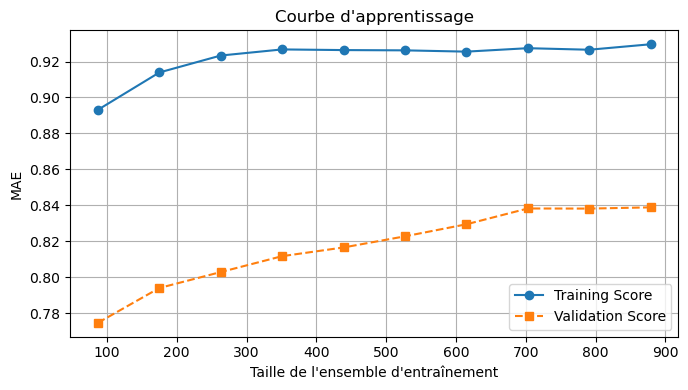

Xgboost
**************************************************


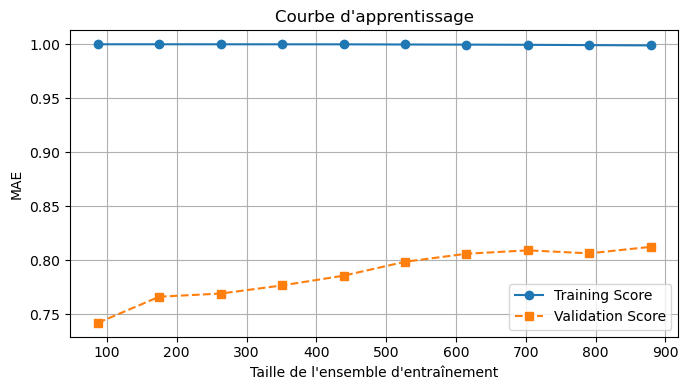

SVM
**************************************************


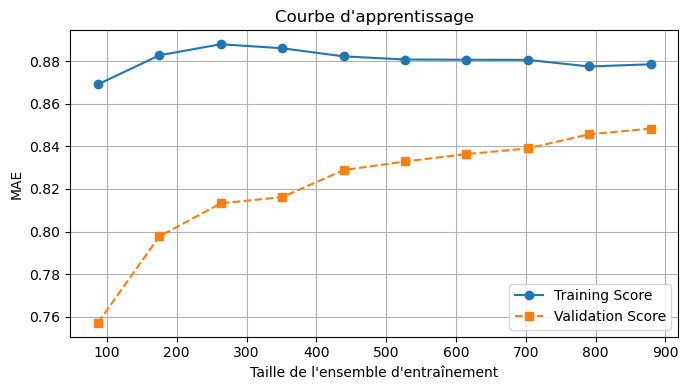

regression_lineaire
**************************************************


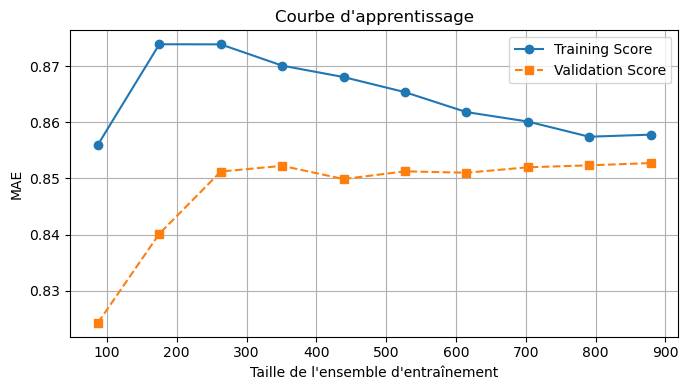

ridge
**************************************************


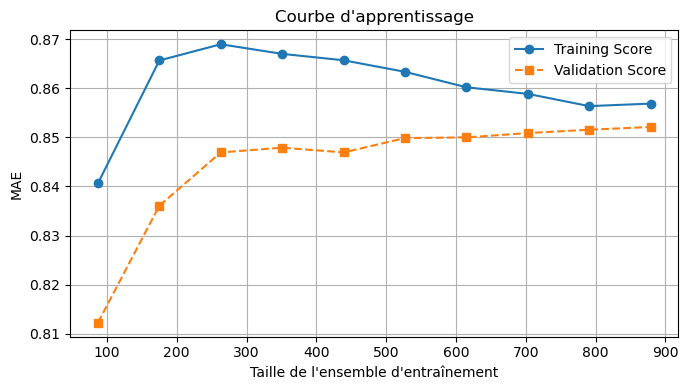

In [668]:
dict_of_modeles = {'RandomForest':RandomForest,
                   'Xgboost': Xgboost,
                   'SVM':SVM,
                   'regression_lineaire':regression_lineaire,
                   'ridge':ridge}

for name,model in dict_of_modeles.items():
    print(name)
    print(50*"*")
    evaluation_courbe_apprentissage(model)

interpretation : 

Les tracés des courbes d'apprentissage montrent que les modèles Random Forest et XGBoost souffrent d'overfitting.
En effet, l'écart entre l'erreur sur l'ensemble d'entraînement et l'erreur de validation est significatif, ce qui indique que ces modèles généralisent mal aux nouvelles données.

Les meilleurs modèles sur les données d'entraînement sont des modèles plus simples tels que la régression linéaire, Ridge et SVM.
Ces modèles semblent mieux équilibrer biais et variance, ce qui les rend plus adaptés aux données disponibles en évitant un surajustement.

In [661]:
print("\n Analyse des performances des modèles:")
fonction_evaluation_cv(X,y)


 Analyse des performances des modèles:


,Train R²,Train MAE,Train RMSE,Val R²,Val MAE,Val RMSE
Ridge,0.88,18273.03,25285.89,0.88,18621.82,25822.68
regression_lineaire,0.88,18324.05,25165.36,0.88,18715.96,25745.86
RandomForest,0.94,12143.43,18016.44,0.86,18823.78,27328.80
SVM,0.91,16032.19,22639.48,0.85,18305.03,27876.92
Xgboost,1.00,1596.56,2333.51,0.84,20520.82,29307.27


interpreation   
- Ridge Regression : Performances stables entre entraînement et validation (R2=0.88 pour les deux), avec une erruer (MAE~18600)

- Régression linéaire : Résultats très proches de Ridge R2=0.88 légèrement moins performante en validation (MAE = 18 715).

- SVM : bien qu'il obtienne un R2 de 0.91 en entrainment, son score en validation est plus faible(0.85) et son RMSE(27 876) est assez élévé Cela suggère qu'il est plus sensible aux variations des données.

- RandomForest et Xgboost ont des très bon score en entrainement (soit 0.94 pour random et 1.00 pour xgboost) et des erreurs faible(MAE), cela montre qu'ils ajustent bien les données d'entrainement. cepandant R2 en validation chutent et les  RMSE augmentent considerablement , indiquant un probleme d'overfitting 

3. Meilleurs modeles 

le choix se fait pour modele de regression Ridge car il a une performances stable entre entrainement et validation avec une erreur (MAE~18600) ce qui est raisonnable. ainsi Ridge et la régression linéaire sont les meilleurs choix car ils offrent un bon compromis entre performance et généralisation.


4. Optimisation des hyperparametre sur les meilleurs modeles 

* Pour la regression Rige 

In [662]:

params = [i for i in np.linspace(1, 2, num=15)]
grid_ridge = GridSearchCV(estimator=ridge,
                          param_grid={'alpha':params},
                          cv=5)
grid_ridge.fit(X,y)
modele_ridge_finale=grid_ridge.best_estimator_  # extrait le meilleur modele 
print(grid_ridge.best_params_)

{'alpha': 1.0}


* Pour SVM 

In [663]:

hyper_params = {'gamma':[1e-3, 1e-4], 
                'C':[1,10,100,1000]}
grid_svm = GridSearchCV(estimator=SVM,
                        param_grid=hyper_params,
                        cv=5)
grid_svm.fit(X,y)
modele_svm_finale = grid_svm.best_estimator_
print(grid_svm.get_params)

<bound method BaseEstimator.get_params of GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001]})>


5. Modeles finales 

In [664]:
modele_ridge_finale=grid_ridge.best_estimator_ 
modele_svm_finale = grid_svm.best_estimator_

6. Prediction finale sur les données de Test

In [673]:
data_test = pd.read_csv("kaggle_test_set.csv", index_col=0)


In [ ]:

test_data = fonction_decoupage_annnes(data_test)
X_test = preprocessing(test_data, choix_variable)

def prediction_sur_test(model, X_test):
    y_test_pred = model.predict(X_test)
    y_test_pred = np.exp(y_test_pred)
    return y_test_pred

<Axes: >

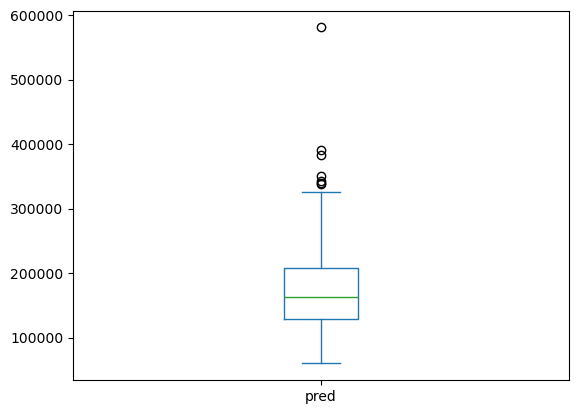

In [670]:
y_pred = prediction_sur_test(modele_ridge_finale,X_test)
d = pd.DataFrame(y_pred,columns=["pred"])
d.plot(kind='box')

7. Sauvegarde des resultats 

In [675]:
# Sauvegarder les prédictions
# submission = pd.DataFrame({"Id": data_test["Id"], "SalePrice": y_pred})
# submission.to_csv("submission.csv", index=False)

# print("Prédictions sauvegardées dans submission.csv !")